In [1]:
import sys
import pickle
import numpy as np
import pandas as pd

sys.path.append('..')
from src.utils import *
from src.configs import *
from tqdm.notebook import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

# SNR = 20db

## Load experiments file

In [2]:
FILENAME = 'Experiments_MASSIVE.xlsx'

In [3]:
exp_df = pd.read_excel(os.path.join('..', 'experiments', FILENAME))
exp_df.head()

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1,300,350
1,MASSIVE001,65459,64,1000,100,20,0.5,5,1,300,350
2,MASSIVE002,30300,64,1000,100,20,0.5,5,1,300,350
3,MASSIVE003,38747,64,1000,100,20,0.5,5,1,300,350
4,MASSIVE004,26932,64,1000,100,20,0.5,5,1,300,350


## Load experiments results (baselines)

In [4]:
models = ['TrueModel', 'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
dict_df = {model: pd.DataFrame(data=0.0, columns=['features_number', 'test_r2_refit', 'train_r2_refit'], index=exp_df['exp_id'].values) for model in models}

for i, exp in tqdm(exp_df.iterrows(), total=len(exp_df)):
    try:
        with open(os.path.join(os.path.join('..', 'results', 'baselines', FILENAME.split('.')[0], 'data'), f'{exp.exp_id}.pickle'), 'rb') as handle:
            results_dict = pickle.load(handle)
        exp_id_tmp, base_opt_results, models, base_results, base_theta = results_dict.values()
        assert(exp.exp_id == exp_id_tmp)

        for model in models:
            dict_df[model].loc[exp_id_tmp, 'features_number'] = exp.features_number
            dict_df[model].loc[exp_id_tmp, ['test_r2_refit', 'train_r2_refit']] = base_results.loc[model, ['test_r2_refit', 'train_r2_refit']]
    except Exception as e:
        print(e)
        #print(f'{exp.exp_id} missing')

  0%|          | 0/140 [00:00<?, ?it/s]

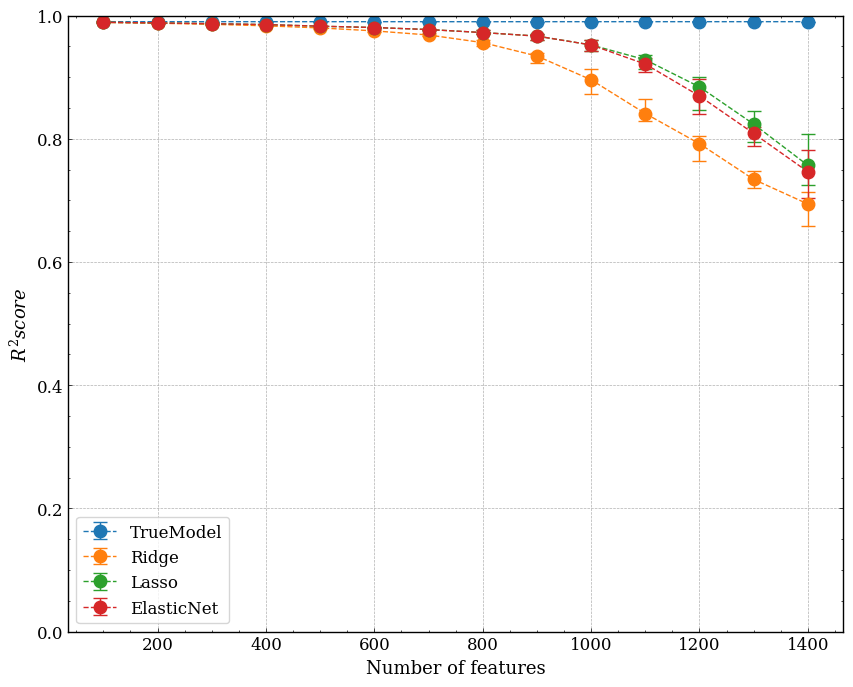

In [5]:
plt.figure(figsize=(10,8))

models = ['TrueModel', 'Ridge', 'Lasso', 'ElasticNet']

for model in models:
    tmp = dict_df[model].copy()
    tmp_grouped = tmp.groupby('features_number')
    plt.errorbar(tmp_grouped.groups.keys(), tmp_grouped['test_r2_refit'].median(),
                 yerr=[tmp_grouped['test_r2_refit'].median()-tmp_grouped['test_r2_refit'].quantile(.05),
                       tmp_grouped['test_r2_refit'].quantile(.95)-tmp_grouped['test_r2_refit'].median()], marker='.', linestyle='--', markersize=18, capsize=5, label=f'{model}')

plt.ylabel(r'$R^2 score$')
plt.xlabel('Number of features')
#plt.xlim(1000,2000)
plt.ylim(0.0, 1.0)
plt.margins(0.05)
plt.legend()

## Load experiments results (Multiridge)

In [6]:
files = ['Experiments_MASSIVE.xlsx']
strategy = 'last'#'best_valid'

dict_df_mr = dict()

for filename in files:
    exp_df = pd.read_excel(os.path.join('..', 'experiments', filename))
    dict_df_mr[exp_df.learning_rate.unique()[0]] = pd.DataFrame(data=0.0, columns=['features_number', 'learning_rate', 'test_r2_refit', 'train_r2_refit', 'mean_valid_r2'], index=exp_df['exp_id'].values)
    
    for i, exp in tqdm(exp_df.iterrows(), total=len(exp_df)):
        try:
            with open(os.path.join(os.path.join('..', 'results', 'multiridge', filename.split('.')[0], 'data'), f'{exp.exp_id}.pickle'), 'rb') as handle:
                results_dict = pickle.load(handle)
            exp_id_tmp, history_df_tmp = results_dict.values()
            
            dict_df_mr[exp.learning_rate].loc[exp_id_tmp, 'features_number'] = exp.features_number
            dict_df_mr[exp.learning_rate].loc[exp_id_tmp, 'learning_rate'] = exp.learning_rate
            if strategy == 'best_valid':
                best_idx = history_df_tmp['mean_valid_r2'].idxmax()
            else:
                best_idx = -1
            dict_df_mr[exp.learning_rate].loc[exp_id_tmp, ['test_r2_refit', 'train_r2_refit', 'mean_valid_r2']] = history_df_tmp.iloc[best_idx][['test_r2_refit', 'train_r2_refit', 'mean_valid_r2']].values
        except Exception as e:
            print(e)

  0%|          | 0/140 [00:00<?, ?it/s]

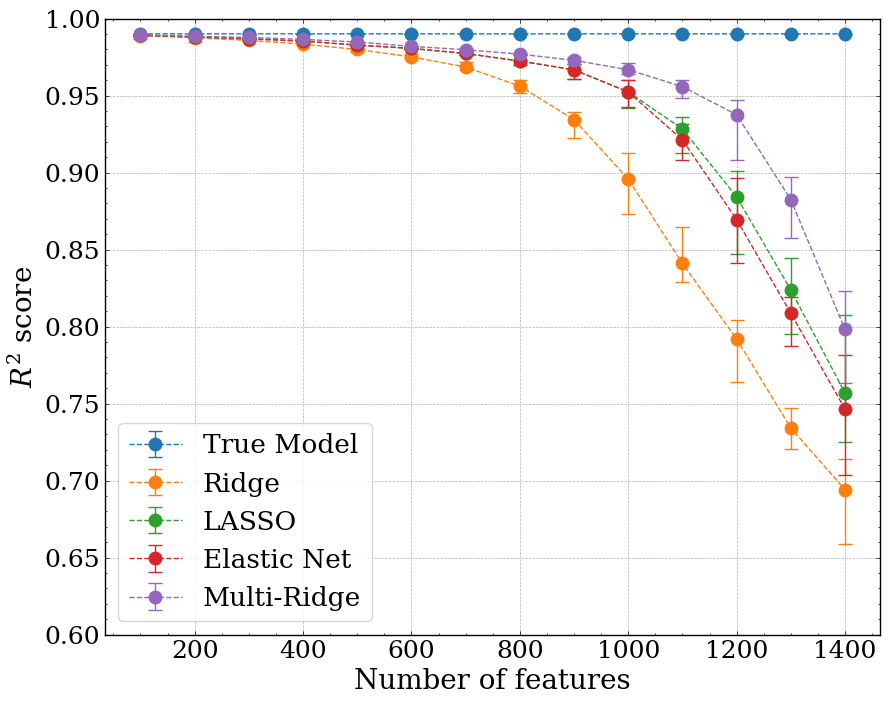

In [9]:
fig_params['axes.labelsize'] = 20
fig_params['xtick.labelsize'] = 18
fig_params['ytick.labelsize'] = 18
fig_params['legend.fontsize'] = 19
fig_params['axes.grid'] = True
rcParams.update(fig_params)

fig = plt.figure(figsize=(10,8))

models = ['TrueModel', 'Ridge', 'Lasso', 'ElasticNet']
labels = ['True Model', 'Ridge', 'LASSO', 'Elastic Net']
learning_rates = [350]#,400,450]

for model,label in zip(models, labels):
    tmp = dict_df[model].copy()
    tmp_grouped = tmp.groupby('features_number')
    plt.errorbar(tmp_grouped.groups.keys(), tmp_grouped['test_r2_refit'].median(),
                 yerr=[tmp_grouped['test_r2_refit'].median()-tmp_grouped['test_r2_refit'].quantile(.05),
                       tmp_grouped['test_r2_refit'].quantile(.95)-tmp_grouped['test_r2_refit'].median()], marker='.', linestyle='--', markersize=18, capsize=5, label=f'{label}')

for lr in learning_rates:
    tmp = dict_df_mr[lr].copy()
    tmp_grouped = tmp.groupby('features_number')
    plt.errorbar(tmp_grouped.groups.keys(), tmp_grouped['test_r2_refit'].median(),
                 yerr=[tmp_grouped['test_r2_refit'].median()-tmp_grouped['test_r2_refit'].quantile(.05),
                       tmp_grouped['test_r2_refit'].quantile(.95)-tmp_grouped['test_r2_refit'].median()], marker='.', linestyle='--', markersize=18, capsize=5, label=f'Multi-Ridge')

plt.ylabel(r'$R^2$ score')
plt.xlabel('Number of features')
#plt.xlim(0,1400)
plt.ylim(0.6, 1.0)
plt.margins(0.05)
plt.legend()

In [10]:
FIG_SIZE = (10, 8)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'massive_experiment',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

In [11]:
FIG_SIZE = (10, 8)
SAVE_FIG = True
FIG_FMT = 'png'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'massive_experiment',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)